<a href="https://colab.research.google.com/github/KHOUTAIBI/NumericalAnalysis-ODE/blob/main/Copie_de_MQ_MOTTIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Méthodes de Quadrature II ** : implémentation

Benjamin MOTTIER
14/03/2025


# I théorie sur la quadrature gaussiene

Dans toute la suite, on considère $\mathcal{X}$ un intervalle de la forme $[a,b]$, $[a,∞[ $ ou $ ]-\infty, a]$, $w$ une fonction définie sur $[a,b]$ positive, continue et d'intégrale normée : $ \int_\mathcal{X} w(x)dx = 1$. C'est une mesure à densité par rapport à la mesure de Lebesgue sur $\mathcal{X}$.

On définit ensuite le produit scalaire :

$$\forall P, Q \in \mathbb{R}[X], (P|Q)_w = \int_\mathcal{X} P(x) Q(x) w(x) dx $$

On trouve théoriquement bien que le produit scalaire est bien définit sur les polynômes. Par conséquent, on peut construire une base orthonormée de polynôme pour ce produit scalaire à partir de la base canonique $(1, X, X^2, X^3,...)$. Une telle base est dite orthonormale et on note de manière générique $P_n$ ses éléments, où $P_n$ est le polynôme orthogonal obtenu au rang n du procédé de Gramm-schimdt.

L'objet de a quadrature gaussienne est de faire une approximation de l'intégrale :

$$ I : f \longmapsto I(f) = \int_\mathcal{X} f(x) w(x) dx$$

par

$$I_n : f \longmapsto I_n(f) = \sum_{i = 0}^{n} w_i f(x_i)$$

Il se trouve que au rang n, une telle méthode de quadrature peut être d'ordre $2n +1$ lorsqu'on considère comme points d'évaluation les racines de $P_{n+1}$  auquels correspondent des $w_i$ qui sont uniques.


# Partie II : Implémentation

Dans la suite, nous allons nous intéresser aux méthodes de quadratures gaussienne sur des intervalle $[a,b]$ et allons commencer par considérer comme fonction $w$ la densité uniforme donnée par :

$$ w : x \longmapsto \frac{1}{b-a} $$

Les polynômes orthogonaux correspondant aussi notés $(P_n)_{n\in \mathbb{N}}$ sont appelés polynômes de Legendre lorsque $a = -1$ et $b = 1$

In [ ]:
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

#8)
Lorsque $w$ est quelconque sur  $[a,b]$, quels sont les changements de variables à appliquer aux $x_i$ ? il s'agit du même changement de variable que celui qui permet de passer d'un poids $w$ à un autre.

#9) implémentation de **gauss_legendre_simple**

In [ ]:
def gauss_legendre_simple(f,a,b,nodes, weights) :
    phi = lambda x : ((b-a)/2) * x + (a+b)/2 # fonction de changement de variable
    nodes = phi(nodes)
    weights = weights * (b-a)/2
    return np.sum( weights * f(nodes))

def f(x) :
    return x**2

def g(x) :
    return np.exp(-x)

nodes, weights = sp.roots_legendre(2)
print("intégrale de x^2  de 0 à 3  pour n = 2: ", gauss_legendre_simple(f,0,3,nodes,weights))
nodes, weights = sp.roots_legendre(10)
print("intégrale de exp(-x)  de 0 à 3 pour n = 10: ", gauss_legendre_simple(g,0,3,nodes,weights))

intégrale de x^2  de 0 à 3  pour n = 2:  8.999999999999996
intégrale de exp(-x)  de 0 à 3 pour n = 10:  0.9502129316321353


# 10) implémentation de **gauss_legendre**

In [ ]:
def gauss_legendre(f, n, M, a, b) :
    psi = lambda x : (b-a) * x + a
    ai = np.array([psi(i/M) for i in range(M+1)])
    nodes, weights = sp.roots_legendre(n)
    S = 0
    for i in range(M):
        S += gauss_legendre_simple(f,ai[i],ai[i+1],nodes,weights)
    return S



print("intégrale de cos de 0 à 2pi avec n = 2 et M = 3: ", gauss_legendre(np.cos, 2 , 3 , 0, 2*np.pi))

print("intégrale de x^2  de 0 à 3  pour n = 2 et M = 3 : ", gauss_legendre(f,2,3,0,3))

print("intégrale de exp(-x)  de 0 à 3 pour n = 2 et M = 3 : ", gauss_legendre(g,2,3,0,3))

intégrale de cos de 0 à 2pi avec n = 2 et M = 3:  -7.771561172376096e-16
intégrale de x^2  de 0 à 3  pour n = 2 et M = 3 :  9.0
intégrale de exp(-x)  de 0 à 3 pour n = 2 et M = 3 :  0.9499997768414076


# 11) Forme vectorielle

In [ ]:
import numpy as np

def gauss_legendre_vectorized(f, n, M, a, b):

    x_i, w_i = sp.roots_legendre(n)

    sub_intervals = np.linspace(a, b, M+1)
    # M+1 car M sous-intervalles

    # changement de variable pour correspondre à l'intervalle [a,b]
    sub_a = sub_intervals[:-1]  # Début des sous-intervalles
    sub_b = sub_intervals[1:]   # Fin des sous-intervalles
    midpoints = (sub_a + sub_b) / 2
    half_widths = (sub_b - sub_a) / 2

    # Transformer les points de Gauss-Legendre pour chaque sous-intervalle
    X_i = midpoints[:, None] + half_widths[:, None] * x_i # (M, n)

    # Évaluer f en tous les points
    F_vectorized = np.vectorize(lambda f: f(X_i), signature='()->(m,n)')

    # 6. Calculer les valeurs des fonctions sans boucle
    F_values = F_vectorized(np.array(F))  # Shape: (k, M, n)

    # Calculer l'intégrale
    integrals = np.sum(F_values * w_i[None, None, :] * half_widths[None, :, None], axis=(1, 2))

    return integrals


def h(x) :
    return np.cos(x)

F = [f,g,h]
print("intégrale de x^2 et exp(-x)  de 0 à 3 pour n = 2 et M = 3 : ", gauss_legendre_vectorized(F,2,3,0,3))

intégrale de x^2 et exp(-x)  de 0 à 3 pour n = 2 et M = 3 :  [9.         0.94999978 0.14108628]


12

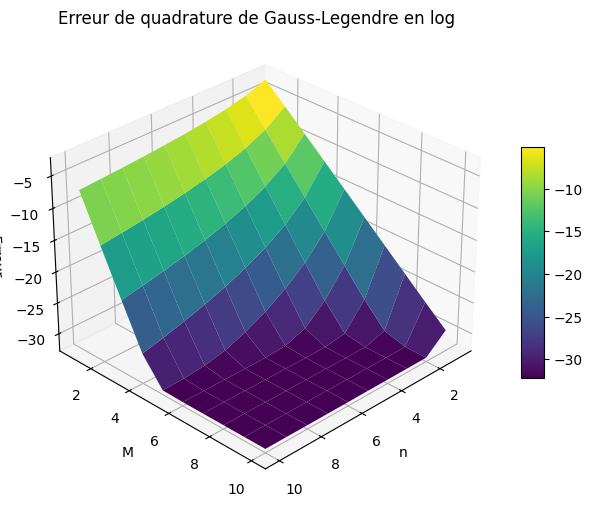

 On remarque que l'erreur logarithmique est minoré par -30 puisque qu'on majore notamment l'erreur par l'erreur de quad de scipy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def fonction(x) :
    return 1/x

ideal_value, e = quad(fonction,2,5)

# Génération de valeurs arbitraires
n = np.array(range(1, 11))
M = np.array(range(1, 11))
errors = np.zeros((len(n), len(M)))

for i in range(len(n)):
    for j in range(len(M)):
        errors[i, j] =np.log( np.abs(ideal_value - gauss_legendre(fonction, n[i], M[j], 2, 5)) + e)

# Création du plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
N, M = np.meshgrid(n, M)
surf = ax.plot_surface(N, M, errors, cmap='viridis')

# Ajout d'une barre de couleur et d'interaction
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.view_init(elev=30, azim=45)  # Angle initial
ax.mouse_init()  # Activation de la manipulation avec la souris


ax.set_xlabel('n')
ax.set_ylabel('M')
ax.set_zlabel('Erreur')
ax.set_title('Erreur de quadrature de Gauss-Legendre en log ')

# Affichage
plt.show()
print(" On remarque que l'erreur logarithmique est minoré par -30 puisque qu'on majore notamment l'erreur par l'erreur de quad de scipy")


13)

In [ ]:
def trapezoidal(f,a,b) :
    return ( f(a) + f(b) ) * ((b-a)/2)

def trapezoidal_composite(f,a,b,M) :
    ai = np.array(range(M+1))
    ai = ai * ((b-a)/M) + a
    S = []
    for i in range(M) :
        S.append(trapezoidal(f,ai[i],ai[i+1]))
    return np.sum(S)

print(trapezoidal_composite(f,0,3,10))
print(trapezoidal_composite(fonction,1,2,10))

9.045000000000002
0.693771403175428


<ipython-input-7-99c5ebf72f29>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


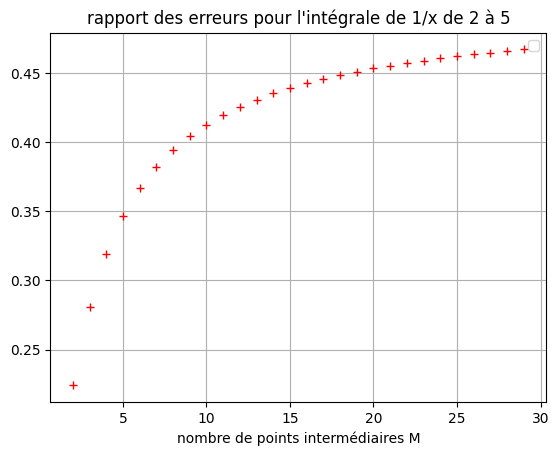

In [ ]:
M = np.array(range(2,30))
errors_trap = np.zeros(len(M))
errors_gauss = np.zeros(len(M))
ideal_value, e = quad(fonction,2,5)
for j in range(len(M)):
    errors_gauss[j] = np.abs(ideal_value - gauss_legendre(fonction, 1, M[j]+1, 2, 5)) +e
    errors_trap[j] =  np.abs(ideal_value - trapezoidal_composite(fonction, 2, 5, M[j]))+e

plt.plot(M,errors_gauss/errors_trap,"r+")
plt.xlabel("nombre de points intermédiaires M")
plt.title("rapport des erreurs pour l'intégrale de 1/x de 2 à 5")
plt.grid()
plt.legend()
plt.show()




On remarque plusieurs choses :
- la première est que le nombre de noeuds considérés pour la méthode composite est de M+1 lorsqu'on fait la méthode composite en M+1 intervalles avec 1 noeud (c'est un choix et on peut tester pour les autres possibilités)
- la seconde est que le rapport des deux erreurs est favorable à la méthode de Gauss-Legendre car le rapport des deux erreurs est inférieur à 1.
- lorsqu'on fait tendre le nombre de points vers l'infini, on remarque que l'erreur est proche de 1/2

Dans la suite on va tester une autres configurations, avec 2 points intermédiaires, 3 points intermédiaires en faisant varier M.


<ipython-input-76-f5041eac4463>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


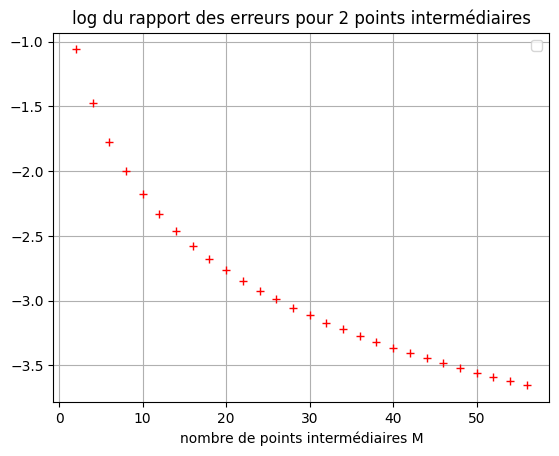

In [ ]:
M = 2 * np.array(range(1,29))
errors_trap = np.zeros(len(M))
errors_gauss = np.zeros(len(M))
ideal_value, e = quad(fonction,2,5)
for j in range(len(M)):
    errors_gauss[j] = np.abs(ideal_value - gauss_legendre(fonction,2, M[j]//2, 2, 5)) +e
    errors_trap[j] =  np.abs(ideal_value - trapezoidal_composite(fonction, 2, 5, M[j]))+e

plt.plot(M,np.log10(errors_gauss/errors_trap),"r+")
plt.xlabel("nombre de points intermédiaires M")
plt.title("log du rapport des erreurs pour 2 points intermédiaires")
plt.grid()
plt.legend()
plt.show()




<ipython-input-77-9b95c20e0f72>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


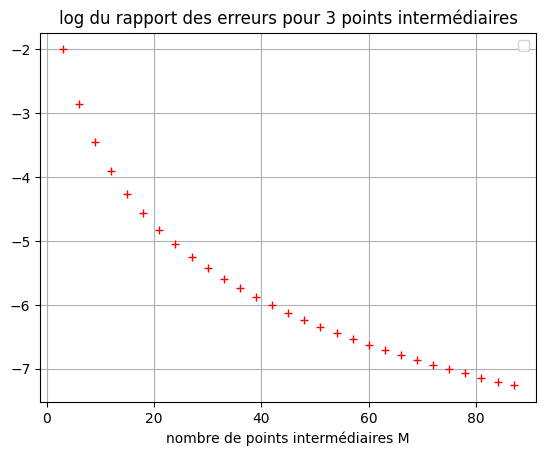

In [ ]:
M = 3 * np.array(range(1,30))
errors_trap = np.zeros(len(M))
errors_gauss = np.zeros(len(M))
ideal_value, e = quad(fonction,2,5)
for j in range(len(M)):
    errors_gauss[j] = np.abs(ideal_value - gauss_legendre(fonction,3, M[j]//3, 2, 5)) +e
    errors_trap[j] =  np.abs(ideal_value - trapezoidal_composite(fonction, 2, 5, M[j]))+e

plt.plot(M,np.log10(errors_gauss/errors_trap),"r+")
plt.xlabel("nombre de points intermédiaires M")
plt.title("log du rapport des erreurs pour 3 points intermédiaires")
plt.grid()
plt.legend()
plt.show()




De manière générale on peut observer l'évolution du log du rapport des erreurs avec le même nombre de noeuds pour M grand.

<ipython-input-10-e482958598b5>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


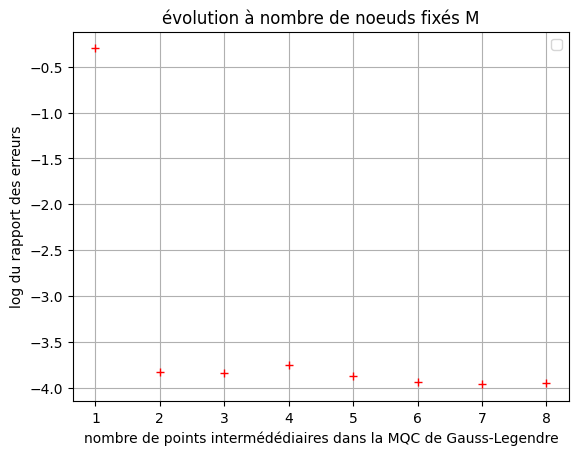

In [ ]:
M = 1*2*3*4*5*6*7*8
errors_trap = np.zeros(8)
errors_gauss = np.zeros(8)
for i in range(1,9):
    errors_gauss[i-1] = np.abs(ideal_value - gauss_legendre(fonction,i, M//i, 2, 5)) +e
    errors_trap[i-1] =  np.abs(ideal_value - trapezoidal_composite(fonction, 2, 5, M))+e
plt.plot(range(1,9),np.log10(errors_gauss/errors_trap),"r+")
plt.xlabel("nombre de points intermédédiaires dans la MQC de Gauss-Legendre")
plt.ylabel("log du rapport des erreurs")
plt.title("évolution à nombre de noeuds fixés M")
plt.grid()
plt.legend()
plt.show()


On remarque finalement que pour un nombre de point important, le rapport des erreurs dans la méthode de Gauss-Legendre est plus précise d'un facteur proche de $10^4$ que la méthode de quadrature classique.

#13) **MINI-PROJET**

Le but du miniprojet est d'implémenter différentes méthodes de quadratures afin d'approcher le plus possible la fonction cumulative de distribution d'une variable aléatoire gaussienne centrée et réduite. Pour cela on va réaliser trois approches :
 - une étandant la méthode des trapèzes vu plus tôt sur des intervalles particuliers
 - une réalisant la méthode de Gauss-Legendre sur des intervalles similaires à ceux précédents.
 - une utlisant la méthode de Gauss-Hermite qui utilise les polynômes orthogaux pour une mesure de poids gaussienne.

 Ces trois méthodes seront comparées à la fonction du module **scipy.stats.norm** : **cdf** qui sera considérée comme une valeur exacte. De plus, on considérera ces modélisations à nombre de noeuds égal.

#13_A) méthode des trapèzes

Dans Toute la suite de ce projet on souhaite définir une fonction
$$\tilde{F}_{trap} : a \longmapsto \sum _0 ^n w_i f(x_i)$$
qui approche le plus possible la fonction cumulative de densité $F$ définie par :
$$F : a ⟼ \mathbb{P}(a\le X) = \int_{-\infty}^a \frac{1}{\sqrt{2 \pi}} e ^{-\frac{x^2}{2}}dx $$

Il est important de remarquer que la méthode des trapèzes et celle de Gauss-Legendre sont définies sur un intervalle de la forme $[\alpha,\beta]$ et que l'intégrale ici est considérée de $- \infty$ à $a$. La démarche que l'on va suivre est de trouver une borne $\alpha (a)$ (dépendant de a) en dessous de laquelle on néglige les termes dans l'intégrale. De sorte que :

$$\forall a, \quad  \biggl\lvert  \int_{-\infty}^a \frac{1}{\sqrt{2 \pi}} e ^{-\frac{x^2}{2}}dx \quad - \quad \int_{\alpha (a)}^a \frac{1}{\sqrt{2 \pi}} e ^{-\frac{x^2}{2}}dx \biggr\rvert \le error$$


# *A Parte*, variable sous-gaussienne

*Cette partie peut être passée pour aller directement au code*

Les distributions normales centrées réduites sont des variables aléatoires sous-gaussienne et vérifient donc l'inégalité de Chernoff :

$$ ∃ C > 0 , \quad \mathbb{P}(|X| \ge a) \le C e^{-\frac{a^2}{2}}$$

donc pour $a > 0$ :
$$ F(a) = \mathbb{P}( X \le a) \le C e^{-\frac{a^2}{2}}$$

Dans le cas où on considère $\alpha(a) = 2a-10$ pour $a$ négatif, on a alors :


$$\forall a < 0, \quad  \biggl\lvert  \mathbb{P}( X \le a) - \quad \int_{\alpha (a)}^a \frac{1}{\sqrt{2 \pi}} e ^{-\frac{x^2}{2}}dx \biggr\rvert = \int_{-\infty}^{2a-10} \frac{1}{\sqrt{2 \pi}} e ^{-\frac{x^2}{2}}dx \quad $$

et

$$
\begin{align*} \mathbb{P}( X \le \alpha(a)) &=  \mathbb{P}( X \le 2a - 10) \\
                                            &\le C e^{-\frac{(2a-10)^2}{2}}\\
            & \le C e^{-\frac{a^2}{2}}e^{-\frac{3a^2-20a + 100}{2}}
\end{align*}$$

On a aussi une borne inférieur pour $ \mathbb{P}( X \le a) $ dont une démonstration se trouve sur  le [site de John D. Cook](https://www.johndcook.com/blog/norm-dist-bounds/) :

$$ \mathbb{P}( X \le a) \ge \frac{1}{\sqrt{2 \pi}} \frac{-a}{a^2 +1} e^{-a^2 /2} $$

Pour $a$ suffisament grand en valeur absolue, il suffit de considérer que :

$$ \mathbb{P}( X \le a) \ge \frac{1}{\sqrt{2 \pi}}  e^{-a^2} $$





En divisant l'inégalité par $\mathbb{P}( X \le a)$  et en réutilisant l'inégalité de Chernoff on en déduit :
$$\begin{align*}
\frac{\mathbb{P}( X \le \alpha(a))}{\mathbb{P}( X \le a)}  &\le C e^{-a^2 }\frac{ e^{-50 + 10a -  a^2}}{\mathbb{P}( X \le a)}  
\end{align*}
$$

On utilise alors la deuxième inégalité obtenue et on a que :

$$
\begin{align*}
\frac{\mathbb{P}( X \le \alpha(a))}{\mathbb{P}( X \le a)}  &\le \sqrt{2 \pi} C e^{-50 + 10a - a^2}
\end{align*}
$$

Or le terme qui majore l'égalité n'est considéré que pour des a négatifs et est croissant sur $\mathbb{R} $donc on a finalement :

$$\quad \frac{\mathbb{P}( X \le 2a-10)}{\mathbb{P}( X \le a)}  \le C \sqrt{2 \pi} e^{-50+10a - a^2}  \biggr\rvert_0 \le C \sqrt{2 \pi} e^{-50} < 10 ^{-20}$$

On déduit de ce résultat que la cdf (cumulative density function) de la gaussienne peut être approchée à $10^{-20}$ près en considérant l'intégrale sur l'intervalle $[2a-10,a]$ pour $a$ négatif. Il est important de noter que cette inégalité est vraie sous la condition que $a$ vérifie :

$$ \frac{-a}{a^2 +1} \le e^{-a^2/2}$$

Ceci est notamment vrai pour  $a < -2$. Dans le cas où $a$ est plus grand, il suffit de considérer $\alpha (a) = -12$  et on retrouve le même encadrement. On a pu conclure ceci sur pour des valeurs de $a$ négatives et on a pour $a$ positif :

$$
\begin{align*}
\mathbb{P}(X \le a) &= 1 - \mathbb{P}(X > a)  \\
                    &= 1 - \mathbb{P}(X \ge a) \qquad \quad\text{ne charge pas les singletons} \\
                    &= 1 - \mathbb{P}(X \le -a) \qquad \text{par symétrie  en 0 de la densité gaussienne}
\end{align*}
$$



# Utilisation des résultats

Le développement ci-dessus permet d'affirmer qu'on peut calculer la fonction recherchée qui est une intégrale en la considérant seulement sur une segment de la forme $[min(2a-10,-12) ; a]$ pour un certain $a$ négatif avec une précision inférieur à $10^{-20}$. Il serait certainement possible d'obtenir un meilleur encadrement en remplaçant la constante devant la transformation affine de a par un nombre proche de 1. Il se trouve que sur les domaines numériques qui nous intéresse ensuite il suffit de prendre $\alpha (a) = a-10 $ pour que l'approximation soit satifaisante. Dans la pratique cette transformation en fonction de $a$ suffit. L'important est qu'on puisse utiliser les méthode de quadrature sur des les intervalles $[\alpha (a) , a]$ avec une grande précision. C'est dans ce contexte qu'on va mettre en place les différentes méthodes, en commençant par la méthode des trapèzes.

# Retour à la méthode des trapèzes

In [ ]:
def n(x) :
    # On définit l'exponentielle
    return np.exp(-x**2 /2) / (np.sqrt(2 * np.pi))

In [ ]:
from scipy.stats import norm
def ref_function(x) :
    return norm.cdf(x)


In [ ]:
def Alpha(a) :
    if a > np.sqrt(2) :
        return -12
    return a - 10

Afin de tester la précision, on compare les méthodes pour des valeurs négatives de a car les valeurs positives étants toutes supérieurs à 1, on observera mal la précision de par la représentation numérique des nombres relatifs (floatants), qui sont très vite infiniment proche de 1 et donc enregistré en mémoir comme égaux à 1,0

In [ ]:
def trap_normal_distrib(a,M) :
    alpha = Alpha(a)
    return trapezoidal_composite(n,alpha,a,M)

print(trap_normal_distrib(-1,10))
print(trap_normal_distrib(-10,10))
print(trap_normal_distrib(0,10))
print(trap_normal_distrib(-30,10))

0.18413094440560637
7.694598630999187e-23
0.500000002675288
2.947292269757095e-196


On compare alors cette évalutation de la cdf avec celle de référence :

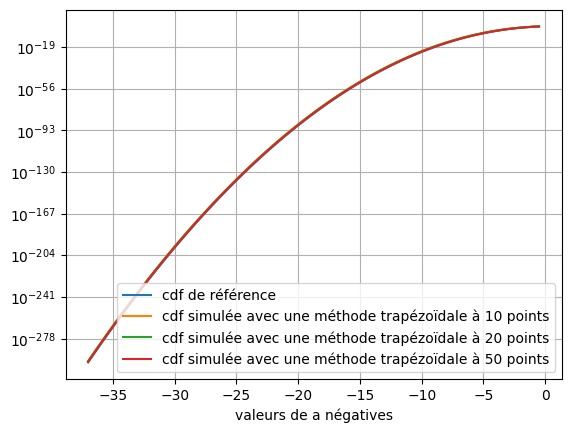

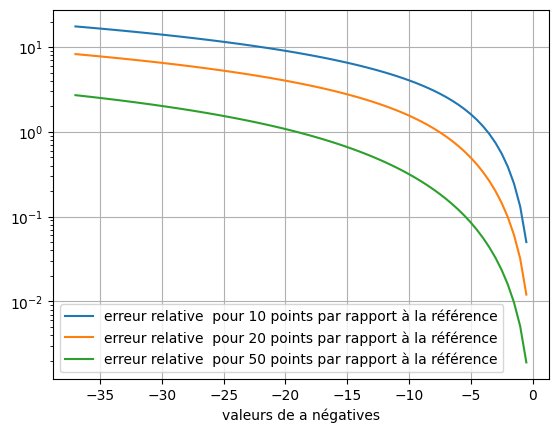

In [ ]:
floats_range = np.arange(-37, 0, 0.5) # n échelonne les valeurs de -37 à 0 car en dessous on a cdf(x) == 0
ref = ref_function(floats_range)
trap10 = np.array([trap_normal_distrib(a,10) for a in floats_range])
trap20 = np.array([trap_normal_distrib(a,20) for a in floats_range])
trap50 = np.array([trap_normal_distrib(a,50) for a in floats_range])
plt.plot(floats_range, ref, label = 'cdf de référence')
plt.plot(floats_range, trap10, label = "cdf simulée avec une méthode trapézoïdale à 10 points")
plt.plot(floats_range, trap20, label = "cdf simulée avec une méthode trapézoïdale à 20 points")
plt.plot(floats_range, trap50, label = "cdf simulée avec une méthode trapézoïdale à 50 points")
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()
plt.plot(floats_range, np.abs(trap10 - ref)/ref, label = 'erreur relative  pour 10 points par rapport à la référence')
plt.plot(floats_range, np.abs(trap20 - ref)/ref, label = 'erreur relative  pour 20 points par rapport à la référence')
plt.plot(floats_range, np.abs(trap50 - ref)/ref, label = 'erreur relative  pour 50 points par rapport à la référence')
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()

On peut remarquer qu'avec seulement 10 points on a une approximation de la cdf qui semble efficace mais l'erreur relative est en fait de l'ordre de $10^2$ pour les valeurs petites de $a$.


# 13_B) méthode de Gauss-Legendre

Dans la suite, on va utiliser la méthode de gauss-legendre composite à nombre de noeud égal en prenant 2 noeuds intermédiaires dans la méthode composite : n = 2 et M = 5,10,25


In [ ]:
def gauss_legendre_normal_distrib(a,M) :
    return gauss_legendre(n, 2, M, Alpha(a), a)

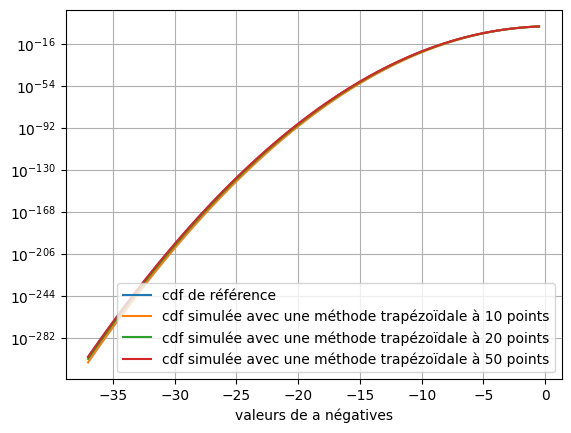

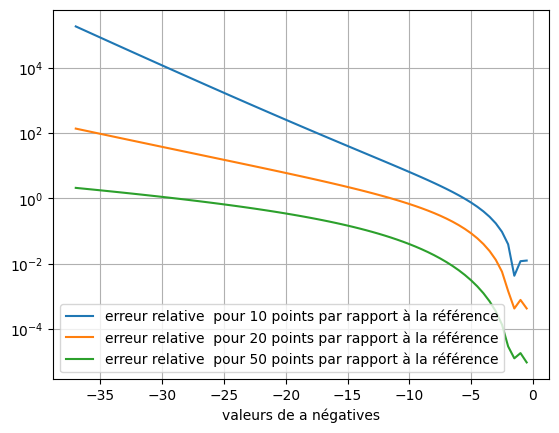

In [ ]:
floats_range = np.arange(-37, 0, 0.5) # n échelonne les valeurs de -37 à 0 car en dessous on a cdf(x) == 0
ref = ref_function(floats_range)
Gauss_Legendre10 = np.array([gauss_legendre_normal_distrib(a,5) for a in floats_range])
Gauss_Legendre20 = np.array([gauss_legendre_normal_distrib(a,10) for a in floats_range])
Gauss_Legendre50 = np.array([gauss_legendre_normal_distrib(a,25) for a in floats_range])
plt.plot(floats_range, ref, label = 'cdf de référence')
plt.plot(floats_range, Gauss_Legendre10, label = "cdf simulée avec une méthode trapézoïdale à 10 points")
plt.plot(floats_range, Gauss_Legendre20, label = "cdf simulée avec une méthode trapézoïdale à 20 points")
plt.plot(floats_range, Gauss_Legendre50, label = "cdf simulée avec une méthode trapézoïdale à 50 points")
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()
plt.plot(floats_range, np.abs(Gauss_Legendre10 - ref)/Gauss_Legendre10, label = 'erreur relative  pour 10 points par rapport à la référence')
plt.plot(floats_range, np.abs(Gauss_Legendre20 - ref)/Gauss_Legendre20, label = 'erreur relative  pour 20 points par rapport à la référence')
plt.plot(floats_range, np.abs(Gauss_Legendre50 - ref)/Gauss_Legendre50, label = 'erreur relative  pour 50 points par rapport à la référence')
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()

On peut remarquer que cette méthode minore la cdf. Et les erreurs qu'on observe sont en puissance bien plus importantes que pour la méthode de quadrature avec des trapèzes. réduire la taille de l'intervalle de mesure peut aider à cela prenons par exemple $\alpha (a) = \min(a-2, -7) $ (déterminé empiriquement).

In [ ]:
def Alpha(a) :
    return min(a-2, -7)

def gauss_legendre_normal_distrib(a,M) :
    return gauss_legendre(n, 2, M, Alpha(a), a)



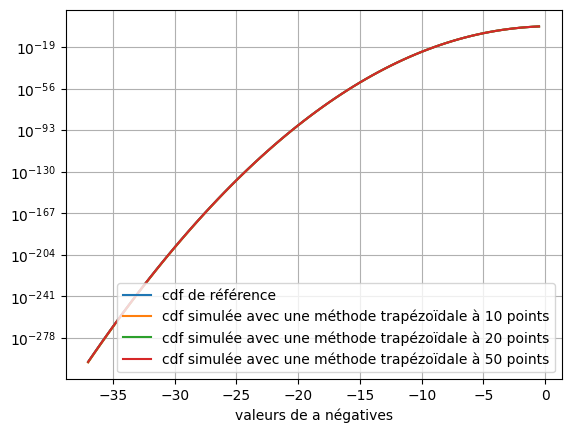

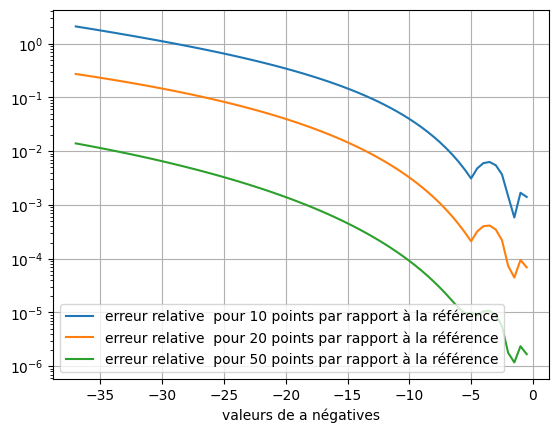

In [ ]:
floats_range = np.arange(-37, 0, 0.5) # n échelonne les valeurs de -37 à 0 car en dessous on a cdf(x) == 0
ref = ref_function(floats_range)
Gauss_Legendre10 = np.array([gauss_legendre_normal_distrib(a,5) for a in floats_range])
Gauss_Legendre20 = np.array([gauss_legendre_normal_distrib(a,10) for a in floats_range])
Gauss_Legendre50 = np.array([gauss_legendre_normal_distrib(a,25) for a in floats_range])
plt.plot(floats_range, ref, label = 'cdf de référence')
plt.plot(floats_range, Gauss_Legendre10, label = "cdf simulée avec une méthode trapézoïdale à 10 points")
plt.plot(floats_range, Gauss_Legendre20, label = "cdf simulée avec une méthode trapézoïdale à 20 points")
plt.plot(floats_range, Gauss_Legendre50, label = "cdf simulée avec une méthode trapézoïdale à 50 points")
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()
plt.plot(floats_range, np.abs(Gauss_Legendre10 - ref)/Gauss_Legendre10, label = 'erreur relative  pour 10 points par rapport à la référence')
plt.plot(floats_range, np.abs(Gauss_Legendre20 - ref)/Gauss_Legendre20, label = 'erreur relative  pour 20 points par rapport à la référence')
plt.plot(floats_range, np.abs(Gauss_Legendre50 - ref)/Gauss_Legendre50, label = 'erreur relative  pour 50 points par rapport à la référence')
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.title("")
plt.grid()
plt.legend()
plt.show()

La raison qui fait que cette méthode est très sensible aux bornes de l'intervalle est que la gaussienne décroit si vite quand $|a|$ grandit qu'elle condense en quelque sorte toute sa densité au bord de l'intervalle le plus proche de 0. Dans ce cas on retient que la méthode des trapèze semble meilleure.

# 13_C) Polynômes de Hermite

Dans cette partie, on va simplement utiliser les polynômes de Hermite qui sont associés à la densité de probabilité de la gaussienne sur $\mathbb{R}$, et pour lequel la méthode numérique consiste à intégrer 1 de $-∞$ à $a$, c'est à dire intéger $\mathbb{1}_{]-\infty, a]}$


In [ ]:
def Gauss_hermite(f,n) :
    x_i, w_i = sp.roots_hermite(n)
    return np.sum(f(x_i)*w_i)

def indicatrice(x,a):
    # Convertit en array pour gérer les scalaires et les tableaux
    x = np.asarray(x, dtype=float)
    a = float(a)  # Assure que 'a' est un scalaire float
    # Applique l'indicatrice sur chaque élément de x
    return (x <= a).astype(int)

def gauss_hermite_normal_distrib(a,M):
    def ind_a(x) :
        return indicatrice(x,a)
    return Gauss_hermite(ind_a,M)

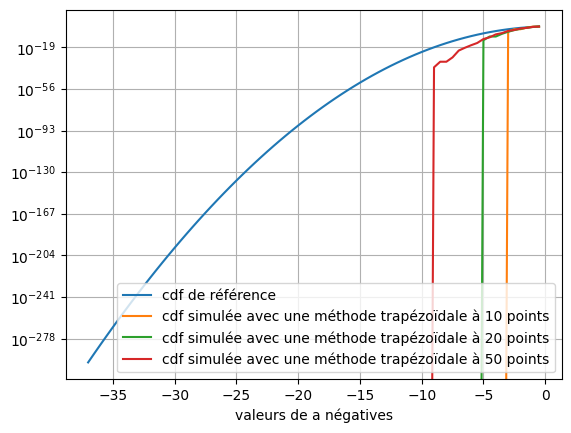

<ipython-input-74-f95c784f9789>:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(floats_range, np.abs(gauss_hermite10 - ref)/gauss_hermite10, label = 'erreur relative  pour 10 points par rapport à la référence')
<ipython-input-74-f95c784f9789>:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(floats_range, np.abs(gauss_hermite20 - ref)/gauss_hermite20, label = 'erreur relative  pour 20 points par rapport à la référence')
<ipython-input-74-f95c784f9789>:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(floats_range, np.abs(gauss_hermite50 - ref)/gauss_hermite50, label = 'erreur relative  pour 50 points par rapport à la référence')


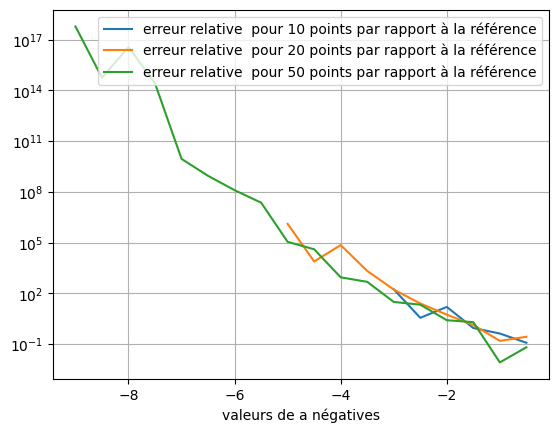

In [ ]:
floats_range = np.arange(-37, 0, 0.5) # n échelonne les valeurs de -37 à 0 car en dessous on a cdf(x) == 0
ref = ref_function(floats_range)
gauss_hermite10 = np.array([gauss_hermite_normal_distrib(a,10) for a in floats_range])
gauss_hermite20 = np.array([gauss_hermite_normal_distrib(a,20) for a in floats_range])
gauss_hermite50 = np.array([gauss_hermite_normal_distrib(a,50) for a in floats_range])
plt.plot(floats_range, ref, label = 'cdf de référence')
plt.plot(floats_range, gauss_hermite10, label = "cdf simulée avec une méthode trapézoïdale à 10 points")
plt.plot(floats_range, gauss_hermite20, label = "cdf simulée avec une méthode trapézoïdale à 20 points")
plt.plot(floats_range, gauss_hermite50, label = "cdf simulée avec une méthode trapézoïdale à 50 points")
plt.yscale('log')

plt.xlabel("valeurs de a négatives")
plt.grid()
plt.legend()
plt.show()
plt.plot(floats_range, np.abs(gauss_hermite10 - ref)/gauss_hermite10, label = 'erreur relative  pour 10 points par rapport à la référence')
plt.plot(floats_range, np.abs(gauss_hermite20 - ref)/gauss_hermite20, label = 'erreur relative  pour 20 points par rapport à la référence')
plt.plot(floats_range, np.abs(gauss_hermite50 - ref)/gauss_hermite50, label = 'erreur relative  pour 50 points par rapport à la référence')
plt.yscale('log')
plt.xlabel("valeurs de a négatives")
plt.title("")
plt.grid()
plt.legend()
plt.show()

A priori cette fonction semble très mauvaise, cela est du à plusieurs raisons.

En premier lieu c'est du au fait que j'ai souhaité le plus possible obtenir des valeurs très faibles de la fonction (celle qui descendent jusqu'à $10^{-300}$. Ce qui présente un intérêt pratique en probabilité assez faible car il est évident qu'un événement qui se produit une fois toute les $10^{50}$ fois est un événement qui ne se produit pas. Néanmoins, tout dépend de ce qu'on souhaite faire avec nos algorithmes.


# Conclusion

Dans ce projet sur le calcul de la fonction de répartition de la gaussienne à l'aide de méthodes de quadrature, j'ai été confronté à plusieurs difficultés :

- **Difficulté théorique** : Trouver les intervalles sur lesquels intégrer. Il est important qu'ils ne soient pas trop grands pour des raisons de précision, notamment dans le cas de la méthode de Gauss-Legendre.
- **Difficulté d'évaluation** : Identifier ce qu'est une bonne approximation. Est-ce son écart à la valeur de référence, sa proximité avec les valeurs utiles de la gaussienne (i.e. dans l'intervalle $[-5,5]$) ?
- **Difficulté d'approche** : Déterminer si les sujets que j'ai approfondis présentent un intérêt réel, la consigne à ce sujet étant très large.

Dans tous les cas, le chemin que j'ai choisi de suivre et la méthode d'intégration qui en découle conduisent à dire qu'à nombre de nœuds égal :

- La méthode des trapèzes est la plus efficace par rapport aux autres méthodes pour les valeurs de points très éloignés de l'origine.
- La méthode de Gauss-Legendre est la meilleure au voisinage de l'origine.
- La méthode de Gauss-Hermite est celle qui semble la plus prometteuse, mais elle ne fonctionne pas bien pour le faible nombre de nœuds que j'ai considéré.